# LOGAN for testing mediation effects

### In the following, we conduct a simulation study to demonstrate the usage of LOGAN. The data generating process is the same as the first simulation scenario in Shi and Li (2020). 

In [1]:
import numpy as np
import scipy
import networkx
import matplotlib.pyplot as plt

import LOGAN.utils as ut
import matplotlib.cm as cm
ut.set_random_seed(12345)
p = 50
W, _ = ut.generate_dag_exam1(p, prob=[0.05, 0.15])

W_star = abs(W).copy()
W_tem = W_star.copy()
for j in range(p+1):
    for i in range(len(W)):
        W_star[i, :] = np.amax(np.minimum(np.outer(W_star[i, :], np.ones(len(W))), abs(W)), axis=0)
    W_tem = np.maximum(W_tem, W_star)
W_star = W_tem.copy()
strength = np.array([W_star[i,0]*W_star[p+1,i] for i in np.arange(1, p+1)])
print(strength)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.06456235 0.
 1.0276047  0.         0.         0.         0.         0.
 0.         0.         0.63224855 0.         0.         0.
 0.         0.         0.         0.         1.08345408 0.
 0.64163798 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.31447262
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


### The matrix `W` corresponds to the weight adjacency matrix. The vector `strength` measures the individual mediation effects. Under $H_0(q)$, the `q`th element in `strength` equals zero. Under $H_1(q)$, it is strictly positive. The larger the absolute value, the stronger the mediation effects. The following code allows us to visualize the adjacency matrix `W`. 

Text(0.5, 1.0, 'True adjacency matrix')

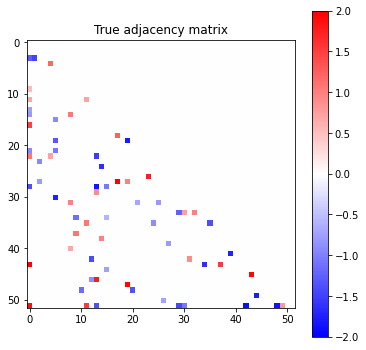

In [2]:
cmap = plt.get_cmap('bwr')
cmap.set_bad(color='white')
fig, ax = plt.subplots(figsize=(6,6))
img = ax.imshow(W, cmap=cmap, vmin=-2, vmax=2)
plt.colorbar(img)
plt.title("True adjacency matrix")

### We next run `M` simulations to investigate the finite sample performance of the proposed test. The following code implements Step 1 and 2 of the proposed test. Specifically,
* Step 1: **Data splitting**. Here `L` denotes the number of data splits. If `L=1`, it reduces to the binary-split test detailed in Section 4 of Shi and Li (2020). If `L>1`, it yields a multi-split test detailed in the appendix. 
* Step 2: **Initial DAG estimation**. We adopt the NOTEARS algorithm to compute `W_est1` and `W_est2`, the estimated adjacency matrices. These matrices will be saved into CSV files. `w` is a thresholding parameter. It is used to ensure the estimated adjacency matrix satisfies the DAG constraint. 

In [3]:
n_sample = 100
M = 1
L = 3
for k in np.arange(1,M+1):
    ut.set_random_seed(12345*k)
    data = ut.simulate_linear_sem(1, W.transpose(), n_sample)

    ## tuning parameter
    lambda1 = 0.5*np.sqrt(np.log(p+1)/(n_sample/2))
    w = 1e-3
    ## sample splitting
    import numpy.random as nr
    import LOGAN.notears as nt
    from numpy import linalg as LA
    import scipy.linalg as slin
    for l in np.arange(1,L+1):
        ut.set_random_seed(1234567*l)
        sample1 = nr.choice(n_sample, int(n_sample/2), replace=False)
        sample2 = [x for x in range(n_sample) if x not in set(sample1)]
        ## form the data subsets and demean
        sub_sample1 = data[sample1, 0:-1].copy()
        sub_sample2 = data[sample2, 0:-1].copy()
        for j in range(p):
            sub_sample1[:,j] = sub_sample1[:,j] - np.mean(sub_sample1[:,j])
            sub_sample2[:,j] = sub_sample2[:,j] - np.mean(sub_sample2[:,j])
        ## apply notears
        W_est1 = nt.notears_linear_l1(sub_sample1, lambda1=lambda1, max_iter=500, loss_type='l2', w_threshold=w) 
        W_est2 = nt.notears_linear_l1(sub_sample2, lambda1=lambda1, max_iter=500, loss_type='l2', w_threshold=w)
        np.savetxt('./results/W_est1'+str(l)+str(k)+'.csv', W_est1, delimiter=',')
        np.savetxt('./results/W_est2'+str(l)+str(k)+'.csv', W_est2, delimiter=',')
    print(k)

1


### The following code implements Step 3 and 4 of the proposed test. Specifically,

* Step 3: **Screening and debiasing**. Functions `_refit`, `_ancestor` and `_decor_score` implement this step. `_refit` is applied to the initial DAG estimator to refit the coefficients with penalized MCP regression (Zhang, 2010). `_ancestor` outputs a boolean matrix that specifies the set of ancestors for each node. `_decor_score` returns the debiased estimate.  
* Step 4: **Bootstrap for critical values**. Here, we directly compute the p-value associated with each mediator (see Section 4.5 of Shi and Li, 2020). The output `test1` is a $p\times 2\times 2L \times M$ matrix, containing the p-values for all $p$ mediators, over all $M$ simulations and $2L$ data splits. `test1[:,0,:,:]` contains p-values for $H_0(q,d+1)$ whereas `test1[:,1,:,:]` contains p-values for $H_0(0,q)$. The output will be saved into a pickle file. 

In [4]:
import pickle
import LOGAN.sparselearn as sl
test1 = np.zeros((p,2,2*L,M))
pickle.dump(test1, open( "./results/n100p50.p", "wb" ) )
n_sample = 100
for k in np.arange(1,M+1):
    ut.set_random_seed(12345*k)
    data = ut.simulate_linear_sem(1, W.transpose(), n_sample)
    for m in np.arange(1,L+1):
        ut.set_random_seed(1234567*m)
        sample1 = nr.choice(n_sample, int(n_sample/2), replace=False)
        sample2 = [x for x in range(n_sample) if x not in set(sample1)]

        w = 1e-3
        W_est1 = np.loadtxt('./results/W_est1'+str(m)+str(k)+'.csv', delimiter=',')
        W_est2 = np.loadtxt('./results/W_est2'+str(m)+str(k)+'.csv', delimiter=',')
        W_est1[:,0] = 0
        W_est2[:,0] = 0
        while True:
            M0 = np.eye(p+1) + W_est1 * W_est1 / (p+1)
            E = np.linalg.matrix_power(M0, p)
            h = (E.T * M0).sum() - (p+1)
            if h<=0:
                break
            else:
                w = 2*w 
                W_est1[np.abs(W_est1)<=w] = 0
        while True:
            M0 = np.eye(p+1) + W_est2 * W_est2 / (p+1)
            E = np.linalg.matrix_power(M0, p)
            h = (E.T * M0).sum() - (p+1)
            if h<=0:
                break
            else:
                w = 2*w 
                W_est2[np.abs(W_est2)<=w] = 0

        critic1 = np.zeros((1000,))
        critic2 = np.zeros((1000,))
        W_refit1 = sl._refit(data[sample1,:], int(n_sample/2), p+2, W_est1)
        W_refit2 = sl._refit(data[sample2,:], int(n_sample/2), p+2, W_est2)

        sub_sample1 = data[sample1, :].copy()
        sub_sample2 = data[sample2, :].copy()
        for j in range(p+1):
            sub_sample1[:,j] = sub_sample1[:,j] - np.mean(sub_sample1[:,j])
            sub_sample2[:,j] = sub_sample2[:,j] - np.mean(sub_sample2[:,j])
        sigma1 = np.mean(np.square(sub_sample2 - sub_sample2 @ W_refit1.transpose()))
        sigma2 = np.mean(np.square(sub_sample1 - sub_sample1 @ W_refit2.transpose()))
        sigma = np.sqrt((sigma1+sigma2)/2)

        B1 = sl._ancestor(W_est1)
        W_ds2, Boot_W2 = sl._decor_score(data[sample2,:], W_refit1, B1)
        W_est_star = sl._W_star(W_ds2.copy(), p)
        for q in np.arange(1, p+1):
            Ind1 = np.full(p+2, True)
            Ind2 = np.full(p+2, True)
            Ind1[B1[:,q]==False] = False
            Ind1[0:-1][B1[p+1,-1]==False] = False
            Ind2[B1[:,q]==False] = False
            Ind2[q] = True
            Ind2[B1[p+1,:]==False] = False
            for l in range(1000):
                Boot_W = np.copy(Boot_W2[:,:,l])
                Boot_W[W_refit1==0] = 0
                if (sum(Ind1)==0)|(sum(Ind2)==0):
                    critic1[l] = 0
                else:
                    critic1[l] = np.amax(abs(Boot_W[np.ix_(Ind1,Ind2)]))*sigma
            test1[q-1,0,2*(m-1),k-1] = np.mean(critic1>=W_est_star[p+1,q])

            Ind1 = np.full(p+2, True)
            Ind2 = np.full(p+2, True)
            Ind1[B1[q,:]==False] = False
            Ind1[q] = True
            Ind1[B1[:,0]==False] = False
            Ind2[B1[:,0]==False] = False
            Ind2[0] = True
            Ind2[B1[q,:]==False] = False
            for l in range(1000):
                Boot_W = np.copy(Boot_W2[:,:,l])
                Boot_W[W_refit1==0] = 0
                if (sum(Ind1)==0)|(sum(Ind2)==0):
                    critic1[l] = 0
                else:
                    critic1[l] = np.amax(abs(Boot_W[np.ix_(Ind1,Ind2)]))*sigma  
            test1[q-1,1,2*(m-1),k-1] = np.mean(critic1>=W_est_star[q,0])

        B2 = sl._ancestor(W_est2)
        W_ds1, Boot_W1 = sl._decor_score(data[sample1,:], W_refit2, B2)
        W_est_star = sl._W_star(W_ds1.copy(), p)
        for q in np.arange(1, p+1):
            Ind1 = np.full(p+2, True)
            Ind2 = np.full(p+2, True)
            Ind1[B2[:,q]==False] = False
            Ind1[0:-1][B2[p+1,-1]==False] = False
            Ind2[B2[:,q]==False] = False
            Ind2[q] = True
            Ind2[B2[p+1,:]==False] = False
            for l in range(1000):
                Boot_W = np.copy(Boot_W1[:,:,l])
                Boot_W[W_refit2==0] = 0
                if (sum(Ind1)==0)|(sum(Ind2)==0):
                    critic2[l] = 0
                else:
                    critic2[l] = np.amax(abs(Boot_W[np.ix_(Ind1,Ind2)]))*sigma
            test1[q-1,0,2*m-1,k-1] = np.mean(critic2>=W_est_star[p+1,q])

            Ind1 = np.full(p+2, True)
            Ind2 = np.full(p+2, True)
            Ind1[B2[q,:]==False] = False
            Ind1[q] = True
            Ind1[B2[:,0]==False] = False
            Ind2[B2[:,0]==False] = False
            Ind2[0] = True
            Ind2[B2[q,:]==False] = False
            for l in range(1000):
                Boot_W = np.copy(Boot_W1[:,:,l])
                Boot_W[W_refit2==0] = 0
                if (sum(Ind1)==0)|(sum(Ind2)==0):
                    critic2[l] = 0
                else:
                    critic2[l] = np.amax(abs(Boot_W[np.ix_(Ind1,Ind2)]))*sigma
            test1[q-1,1,2*m-1,k-1] = np.mean(critic2>=W_est_star[q,0])
    
    pickle.dump(test1, open( "./results/n100p50.p", "wb" ) )
    print(k)

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

### Comparison with the test of Chakrabortty et al. (2018), MIDA. The following code implements the MIDA test over `M` simulations. The p-values are given by `pv` at the end

In [5]:
import numpy.matlib
Est = np.zeros((p,M))
Std = np.zeros((p,M))
for k in np.arange(1,M+1):
    ut.set_random_seed(12345*k)
    data = ut.simulate_linear_sem(1, W.transpose(), n_sample)

    ## tuning parameter
    lambda1 = 0.5*np.sqrt(np.log(p+1)/(n_sample))
    w = 1e-3
    ## sample splitting
    import numpy.random as nr
    import LOGAN.notears as nt
    from numpy import linalg as LA
    import scipy.linalg as slin
    ## form the data subsets and demean
    sample = data[:, 0:-1].copy()
    for j in range(p):
        sample[:,j] = sample[:,j] - np.mean(sample[:,j])
    ## apply notears
    W_est = nt.notears_linear_l1(sample, lambda1=lambda1, max_iter=500, loss_type='l2', w_threshold=w) 
    
    W_est[:,0] = 0
    while True:
        M0 = np.eye(p+1) + W_est * W_est / (p+1)
        E = np.linalg.matrix_power(M0, p)
        h = (E.T * M0).sum() - (p+1)
        if h<=0:
            break
        else:
            w = 2*w 
            W_est[np.abs(W_est)<=w] = 0

    W_refit = sl._refit(data, n_sample, p+2, W_est)
    sample = data.copy()
    for j in range(p+1):
        sample[:,j] = sample[:,j] - np.mean(sample[:,j])
    sigma = np.sqrt(np.mean(np.square(sample - sample @ W_refit.transpose())))

    for j in np.arange(1,p+1):
        lsfit1 = np.linalg.lstsq(np.vstack([np.ones(n_sample), data[:,0]]).transpose(), data[:,j], rcond=None)
        Index = np.full(p+2, False)
        Index[W_refit[j,:]!=0] = True
        Index[0] = True
        Index[j] = True
        lsfit2 = np.linalg.lstsq(np.vstack([np.ones(n_sample), data[:,Index].transpose()]).transpose(), data[:,-1], rcond=None)

        Est[j-1,k-1] = lsfit1[0][1]*lsfit2[0][sum(Index)]
        mat1 = np.vstack([np.ones(n_sample), data[:,0]]).transpose()
        mat2 = np.vstack([np.ones(n_sample), data[:,Index].transpose()]).transpose()
        res1 = data[:,j]-np.dot(mat1, lsfit1[0])
        res2 = data[:,-1]-np.dot(mat2, lsfit2[0])
        matres1 = np.multiply(np.matlib.repmat(res1, 2, 1).transpose(), mat1)
        matres2 = np.multiply(np.matlib.repmat(res2, sum(Index)+1, 1).transpose(), mat2)
        matmat1 = np.dot(mat1.transpose(), mat1)
        matmat2 = np.dot(mat2.transpose(), mat2)
        vec = lsfit2[0][sum(Index)]*np.linalg.solve(matmat1, matres1.transpose())[1,:]
        vec = vec + lsfit1[0][1]*np.linalg.solve(matmat2, matres2.transpose())[sum(Index),:]
        Std[j-1,k-1] = np.linalg.norm(vec, 2)*sigma
    
    print(k)

from scipy.stats import norm
pv = 2*(1-norm.cdf(abs(Est)[:,np.sum(abs(Est),0)>0]/Std[:,np.sum(abs(Est),0)>0]))

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
1


### The following code compares the two tests using the ROC curve. The individual p-values of the proposed test are given by `pvalue1` below.

<ipython-input-6-3d4510709ff9>:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tpr = interp(base_fpr, fpr, tpr)
<ipython-input-6-3d4510709ff9>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tpr = interp(base_fpr, fpr, tpr)


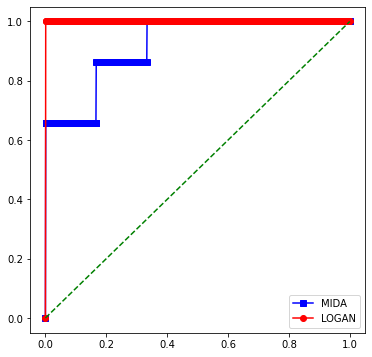

In [6]:
test1 = pickle.load( open( "./results/n100p50.p", "rb" ) )
pvalue1 = np.zeros((p,2,M))
for k in np.arange(0,M):
    for l in range(2):
        gamma = 0.1
        pvalue1[:,l,k] = np.quantile(test1[:,l,:,k]/gamma, gamma, axis=1)
pvalue1 = np.maximum(pvalue1[:,0,:], pvalue1[:,1,:])
pvalue1[pvalue1>1] = 1

import numpy as np
from scipy import interp
from sklearn.metrics import roc_curve
tprs = []
base_fpr = np.linspace(0, 1, 1001)
for i in np.arange(0,M):
    fpr, tpr, _ = roc_curve(strength==0, pv[:,i], pos_label=1)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

tprs1 = []
for i in np.arange(0,M):
    fpr, tpr, _ = roc_curve(strength==0, pvalue1[:,i], pos_label=1)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs1.append(tpr)
    
tprs1 = np.array(tprs1)
mean_tprs1 = tprs1.mean(axis=0)
std1 = tprs1.std(axis=0)

tprs1_upper = np.minimum(mean_tprs1 + std1, 1)
tprs1_lower = mean_tprs1 - std1

import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=1, figsize=(6,6))
ax.plot(base_fpr, mean_tprs, 'bs-', label='MIDA')
ax.plot(base_fpr, mean_tprs1, 'ro-', label='LOGAN')
ax.plot([0, 1], [0, 1],'g--')
ax.legend(loc='best')

### The following code implements the proposed multiple testing procedure, based on the proposed test, the ScreenMin (Djordjilovic et al., 2019) and the Benjamini-Yekutieli (BY, Benjamini and Yekutieli, 2001) procedure.

In [7]:
test1 = pickle.load( open( "./results/n100p50.p", "rb" ) )
base_q = np.linspace(0, 0.4, 21)
len_base = len(base_q)
pvalue0 = np.zeros((p, M, len_base, 2))
fdr = np.zeros((M, len_base))
tpr = np.zeros((M, len_base))
test = np.zeros((p, M, len_base))
for m in range(len_base):
    threshold0 = base_q[m]/np.arange(1,p+1)
    for k in range(M):
        for l in range(2):
            for j in np.arange(1,p+1):
                set0 = np.minimum(test1[:,0,l,k], test1[:,1,l,k])<=threshold0[j-1]
                if threshold0[j-1]*sum(set0) <= base_q[m]:
                    break
            pvalue0[:,k,m,l] = np.maximum(test1[:,0,l,k], test1[:,1,l,k])
            pvalue0[~set0,k,m,l] = 1
    for k in range(M):
        for l in range(2):
            set0 = pvalue0[:,k,m,l]<1
            h = (pvalue0[set0,k,m,l][np.argsort(pvalue0[set0,k,m,l])])<=np.arange(1,1+sum(set0))*base_q[m]/(2*sum(set0)*(0.5+np.log(max(1,sum(set0)))))
            if sum(h)>0:
                test2 = np.zeros(sum(set0))
                test2[np.argsort(pvalue0[set0,k,m,l])[0:sum(h)]] = 1
                test[set0,k,m] = test2
    for k in range(M):
        fdr[k,m] = sum(test[strength==0,k,m])/(p-sum(strength!=0))
        tpr[k,m] = sum(test[strength!=0,k,m])/sum(strength!=0)

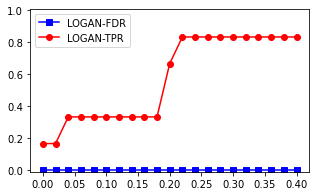

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
ax.plot(base_q, np.mean(fdr, axis=0), 'bs-', label='LOGAN-FDR')
ax.plot(base_q, np.mean(tpr, axis=0), 'ro-', label='LOGAN-TPR')
ax.set_ylim([-0.01,1.01])
ax.legend(loc='best')